# Exploratory Data Analysis - Ultrsound Nerve Segmentation

In [1]:
import os, glob,  cv2
import numpy as np
from progress_bar import log_progress

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

# About the Raw Data

The dataset contains .tif sonogram images (X features) and image masks (y labels) that are postfixed with `_mask.tif` in the filename. The first step is to load the raw images into numpy arrays. 

**NOTE**. The github repo only contains a very small sample of the 5000+ training images. To run this notebook on the full dataset, download the training data at https://www.kaggle.com/c/ultrasound-nerve-segmentation/data, then change the directory constants to the proper location. 


In [2]:
TRAIN_DIR = 'data/train/'
TEST_DIR = 'data/test/'

# Raw Image Size
IMAGE_ROWS = 420
IMAGE_COLS = 580

# Downsized Image Size
MIN_ROWS = 64
MIN_COLS = 80

train_images = [i for i in os.listdir(TRAIN_DIR) if 'mask' not in i]
test_images =  [i for i in os.listdir(TEST_DIR)]

TRAIN_COUNT = len(train_images)
TEST_COUNT =  len(test_images)

def read_image(file_path):
    return cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

def read_train():

    train = np.ndarray((TRAIN_COUNT, 1, IMAGE_ROWS, IMAGE_COLS), dtype=np.uint8)
    masks = np.ndarray((TRAIN_COUNT, 1, IMAGE_ROWS, IMAGE_COLS), dtype=np.uint8)

    print('Reading training images...')
    for i, image_file in enumerate(log_progress(train_images)):
        image = read_image(TRAIN_DIR+image_file)
        image = np.array([image])
        train[i] = image 

        mask_file = image_file.split('.')[0] + '_mask.tif'
        mask = read_image(TRAIN_DIR+mask_file)
        mask = np.array([mask])
        masks[i] = mask
        
    print('Train data processed!')
    return train, masks

def read_test():
    
    test = np.ndarray((TEST_COUNT, 1, IMAGE_ROWS, IMAGE_COLS), dtype=np.uint8)
    test_ids = np.ndarray((TEST_COUNT, ), dtype=np.int32)
    print('Reading test images...')
    for i, image_file in enumerate(log_progress(test_images)):
        image_id = int(image_file.split('.')[0])
        image = read_image(TEST_DIR+image_file)
        image = np.array([image])
        test[i] = image  
        test_ids[i] = image_id
        
    
    print('Test data processed!')
    return test, test_ids
    

train, masks = read_train()
test, test_ids = read_test()

Reading training images...
Train data processed!
Reading test images...
Test data processed!


## Exploring Mask Annotations

Now that the images are loaded into ndarrays, we can start doing some exploratory analysis. The first piece of information to the porportion of blank masks to annotated masks. 

Grayscale images have a pixel value ranging from 0 (black) to 255 (white). Finding annotations is as simple as calculating the sum of the entire array, where arrays with a sum equaling 0 are blank. 

41% of masks have annotations. 

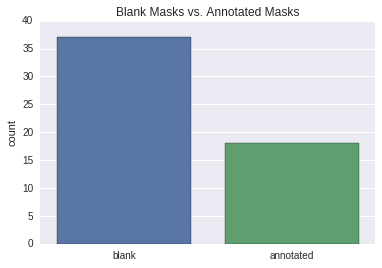

In [3]:
def find_annotated_masks():
    annotations = []
    for mask in masks:
        if np.sum(mask[0]) > 0:
            annotations.append('annotated') # mask present
        else: 
            annotations.append('blank') # mask blank
    return np.array(annotations)

annotations = find_annotated_masks()
sns.countplot(annotations)
sns.plt.title('Blank Masks vs. Annotated Masks')

## Side-by-Side Visual Analysis

Below is a sample of the training images (X) with their masks (y). A visual examination highlights the difficulty indentifying the BP nerve without prior medical training. 

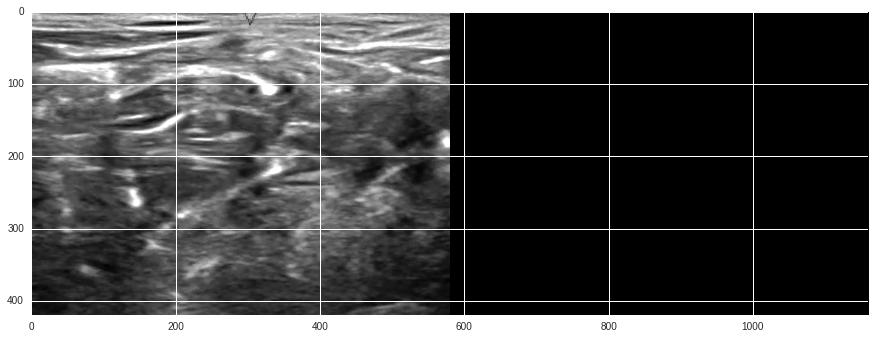

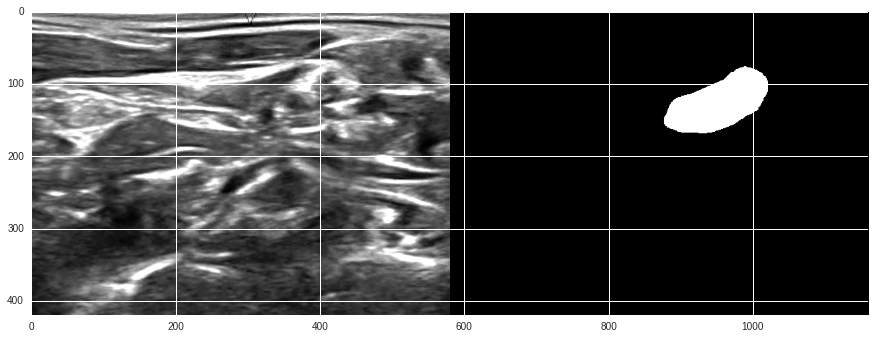

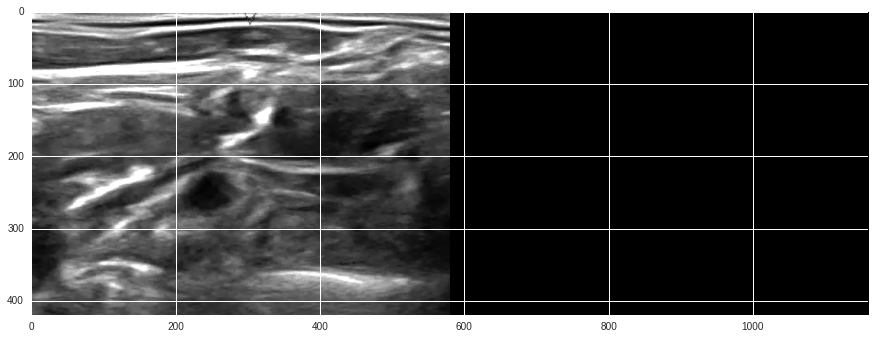

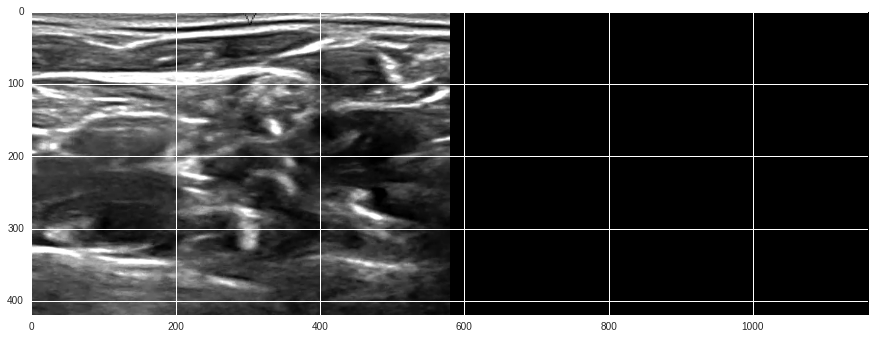

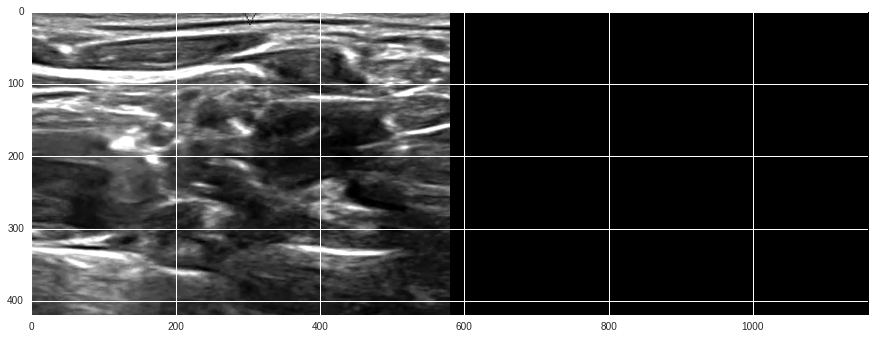

In [4]:
def show_img_with_mask(idx):
    img = train[idx][0]
    mask = masks[idx][0]
    pair = np.concatenate((img, mask), axis=1)
    plt.figure(figsize=(15,20))
    plt.imshow(pair, cmap='gray')
    
for idx in range(0,5):
    show_img_with_mask(idx)

## Average Mask Size


1. The first image shows the average mask arcoss the entire dataset. 

2. The second image provides applies a logrithmic correction to retain the seperation between masks. 

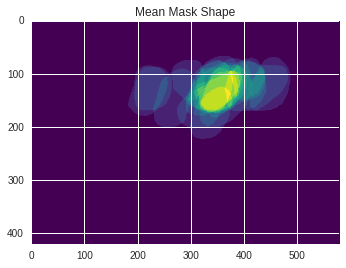

In [5]:
mask_avg = np.array([mask[0] for mask in masks]).mean(axis=0)
plt.imshow(mask_avg, cmap='viridis')
plt.title('Mean Mask Shape')

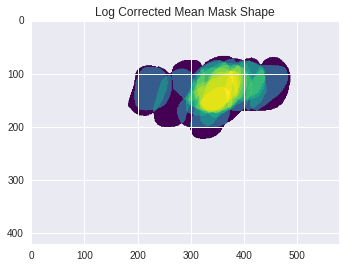

In [6]:
plt.imshow(np.log(mask_avg), cmap='viridis')
plt.title('Log Corrected Mean Mask Shape')

## Pixel Distribution in Sonogram Images

For the training images, it is important to understand the distribution of pixels in the dataset. 

1. Mean pixel distribution across all images.
2. Mean pixel distribution on images with blanks masks.
2. Mean pixel distribution on images with annotated masks.

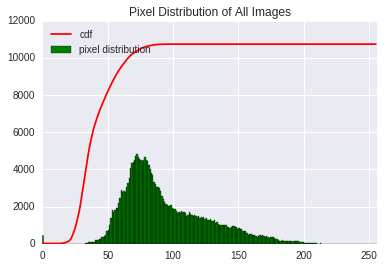

In [7]:
imgs = np.array([img[0] for img in train])
img = imgs.mean(axis=0)

def show_img_hist(img, title):
    hist,bins = np.histogram(img.flatten(),256,[0,580])
    # cumulative distribution function
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()

    plt.plot(cdf_normalized, color = 'red')
    plt.hist(img.flatten(),256,[0,256], color = 'green')
    plt.xlim([0,256])
    plt.legend(('cdf','pixel distribution'), loc = 'upper left')
    plt.title(title)
    
show_img_hist(img, "Pixel Distribution of All Images")

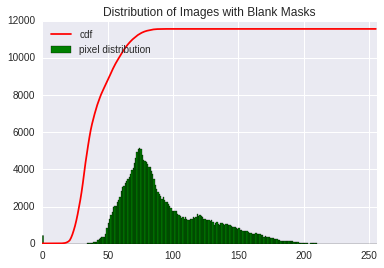

In [8]:
imgs = np.array([img[0] for i, img in enumerate(train) if annotations[i] == 'blank'] )
img = imgs.mean(axis=0)
show_img_hist(img, "Distribution of Images with Blank Masks")

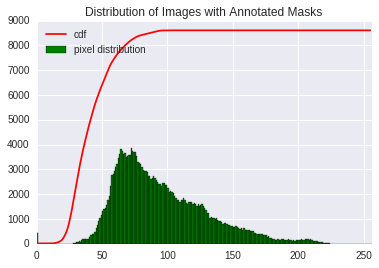

In [9]:
imgs = np.array([img[0] for i, img in enumerate(train) if annotations[i] == 'annotated'] )
img = imgs.mean(axis=0)
show_img_hist(img, "Distribution of Images with Annotated Masks")

## Applying Hisogram Equalization

Balancing the brightness/contrast of the images can be achieved with historgram equalization. The goal is to balance the cumulative distribution function (CDF) into an even slope. Later, this will be applied to each individual image. 

When compared side-by-side, the equalized images are less noisy and maintain better visual serperation between features. 

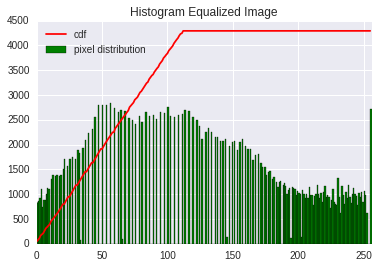

In [10]:
img = train[0, 0] # first image
img = cv2.equalizeHist(img)
show_img_hist(img, "Histogram Equalized Image")

## Preprocessing Decisions and Justification

1. Gaussian Blur - Smooths sharp edges to prevent false poitives.
2. Histogram Equalization - Balances brightness/contast for improved feature detection
3. Resize - Resize to 64x80 to limit number of parameters and memory required for the neural network.


In [11]:
def preprocess(imgs, sonogram=True):
    processed_images = np.ndarray((imgs.shape[0], imgs.shape[1], MIN_ROWS, MIN_COLS), dtype=np.uint8)
    for i in range(imgs.shape[0]):
        img = imgs[i, 0]
        if(sonogram):
            img = cv2.GaussianBlur(img,(7,7),0)
            img = cv2.equalizeHist(img)
        processed_images[i, 0] = cv2.resize(img, (MIN_COLS, MIN_ROWS), interpolation=cv2.INTER_CUBIC)
    processed_images = processed_images.astype('float32') # Float 32 for GPU usage
    return processed_images


train = preprocess(train)
print "Train Data Shape: {}".format(train.shape)

masks = preprocess(masks, sonogram=False)
masks /= 255.0 # converts all mask pixels from 255 to 1
print "Mask Labels Shape: {}".format(masks.shape)

test = preprocess(test)
print "Test Data Shape: {}".format(test.shape)

Train Data Shape: (55, 1, 64, 80)
Mask Labels Shape: (55, 1, 64, 80)
Test Data Shape: (24, 1, 64, 80)


## Dice Coefficient

In order to calculate the dice coefficient, it is necessary to perform operations on Theano TensorVariables which can be accessed via the backend API in Keras. 

In [12]:
def dice(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    coef = (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)
    return coef

def dice_loss(y_true, y_pred):
    loss = 1 - dice(y_true, y_pred)
    return loss

# U-Net Convolutional Neural Network

Sources:

- [U-Net: Convolutional Networks for Biomedical Image Segmentation](https://arxiv.org/pdf/1505.04597.pdf)
- [U-Net Keras Adaptation](https://github.com/jocicmarko/ultrasound-nerve-segmentation)

In [13]:
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D
from keras.optimizers import Adam
from keras import backend as K

f = 3                       # filter size 3x3
strides = (2, 2)            # strides for pooling/upsampling
optimizer = Adam(lr=1e-5)   # optimizer


def u_net():
    input_img = Input((1, MIN_ROWS, MIN_COLS))
    
    c1 = Convolution2D(32, f, f, activation='relu', border_mode='same')(input_img)
    c1 = Convolution2D(32, f, f, activation='relu', border_mode='same')(c1)
    p1 = MaxPooling2D(pool_size=strides)(c1)

    c2 = Convolution2D(64, f, f, activation='relu', border_mode='same')(p1)
    c2 = Convolution2D(32, f, f, activation='relu', border_mode='same')(c2)
    p2 = MaxPooling2D(pool_size=strides)(c2)

    c3 = Convolution2D(128, f, f, activation='relu', border_mode='same')(p2)
    c3 = Convolution2D(128, f, f, activation='relu', border_mode='same')(c3)
    p3 = MaxPooling2D(pool_size=strides)(c3)

    c4 = Convolution2D(256, f, f, activation='relu', border_mode='same')(p3)
    c4 = Convolution2D(256, f, f, activation='relu', border_mode='same')(c4)
    p4 = MaxPooling2D(pool_size=strides)(c4)

    c5 = Convolution2D(512, f, f, activation='relu', border_mode='same')(p4)
    c5 = Convolution2D(512, f, f, activation='relu', border_mode='same')(c5)

    up6 = merge([UpSampling2D(size=strides)(c5), c4], mode='concat', concat_axis=1)
    c6 = Convolution2D(256, f, f, activation='relu', border_mode='same')(up6)
    c6 = Convolution2D(256, f, f, activation='relu', border_mode='same')(c6)

    up7 = merge([UpSampling2D(size=strides)(c6), c3], mode='concat', concat_axis=1)
    c7 = Convolution2D(128, f, f, activation='relu', border_mode='same')(up7)
    c7 = Convolution2D(128, f, f, activation='relu', border_mode='same')(c7)

    up8 = merge([UpSampling2D(size=strides)(c7), c2], mode='concat', concat_axis=1)
    c8 = Convolution2D(64, f, f, activation='relu', border_mode='same')(up8)
    c8 = Convolution2D(64, f, f, activation='relu', border_mode='same')(c8)

    up9 = merge([UpSampling2D(size=strides)(c8), c1], mode='concat', concat_axis=1)
    c9 = Convolution2D(32, f, f, activation='relu', border_mode='same')(up9)
    c9 = Convolution2D(32, f, f, activation='relu', border_mode='same')(c9)
    
    output = Convolution2D(1, 1, 1, activation='sigmoid')(c9)

    model = Model(input=input_img, output=output)
                      
    model.compile(optimizer=optimizer, 
                  loss=dice_loss, 
                  metrics=[dice])

    return model


model = u_net()
model.summary()

Using Theano backend.
Using gpu device 0: GeForce GTX 1070 (CNMeM is disabled, cuDNN 5005)


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 1, 64, 80)     0                                            
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 32, 64, 80)    320         input_1[0][0]                    
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 32, 64, 80)    9248        convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 32, 32, 40)    0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [14]:
nb_epoch = 30
batch_size = 64

def run_u_net():
    
    model.fit(train, masks, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.1, verbose=1, shuffle=True)

    predictions = model.predict(test, verbose=1) # predicts mask
    return predictions

predictions = run_u_net()

Train on 49 samples, validate on 6 samples
Epoch 1/30
49/49 [==============================] - 0s - loss: 0.9989 - dice: 0.0011 - val_loss: 0.9983 - val_dice: 0.0017
Epoch 2/30
49/49 [==============================] - 0s - loss: 0.9986 - dice: 0.0014 - val_loss: 0.9978 - val_dice: 0.0022
Epoch 3/30
49/49 [==============================] - 0s - loss: 0.9982 - dice: 0.0018 - val_loss: 0.9972 - val_dice: 0.0028
Epoch 4/30
49/49 [==============================] - 0s - loss: 0.9976 - dice: 0.0024 - val_loss: 0.9964 - val_dice: 0.0036
Epoch 5/30
49/49 [==============================] - 0s - loss: 0.9970 - dice: 0.0030 - val_loss: 0.9954 - val_dice: 0.0046
Epoch 6/30
49/49 [==============================] - 0s - loss: 0.9963 - dice: 0.0037 - val_loss: 0.9943 - val_dice: 0.0057
Epoch 7/30
49/49 [==============================] - 0s - loss: 0.9954 - dice: 0.0046 - val_loss: 0.9929 - val_dice: 0.0071
Epoch 8/30
49/49 [==============================] - 0s - loss: 0.9943 - dice: 0.0057 - val_loss:

## Analysis of the U-Net Mask Predictions

- Training: 0.6503
- Validation: 0.600

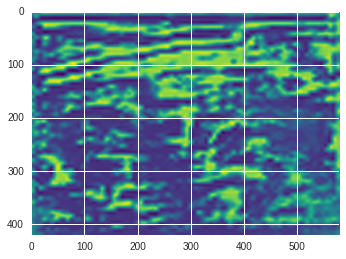

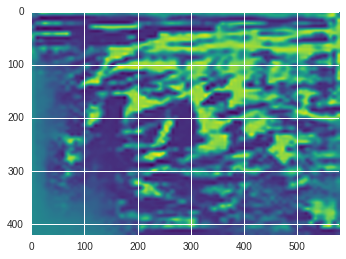

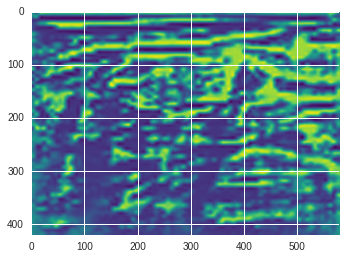

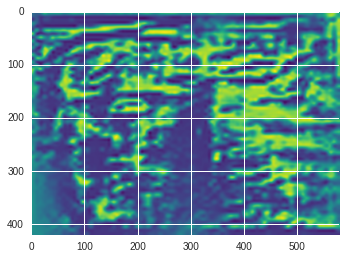

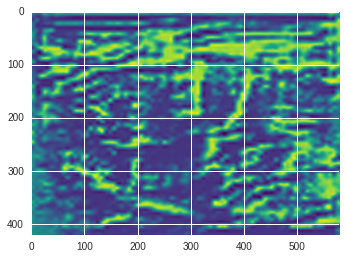

In [15]:
for i in range(0,5):
    pred = predictions[i][0]
    pred = cv2.resize(pred, (IMAGE_COLS, IMAGE_ROWS), interpolation=cv2.INTER_CUBIC)
    plt.imshow(pred, cmap='viridis')
    plt.show()

## Final Processing

Before making a submission to Kaggle, it is necessary to filter out blank masks. Blank masks can be determined by the amount of encoding performed by the neural network. If a predicted mask does not meet a certain threshhold, it will be filtered out by setting all pixel values to zero. 

The training set is slightly unbalanced with only 41% of images having annoations. The threshold will be set equal to the 60th percentile of the sums of the prediction arrays. In other words, only the largest 40% of predicted masks will be retained, while the others will be considered blank. 

In [16]:
prediction_sums = [pred[0].sum() for pred in predictions]
threshold = np.percentile(prediction_sums, 60.0)
print "Filter Threshold set to {0}".format(threshold)

def remove_false_positives(predictions, threshold):   
    for i, pred in enumerate(predictions):    
        if np.sum(pred) < threshold:
            predictions[i][0] = pred * 0

    return predictions

final_predictions = remove_false_positives(predictions, threshold)
print "Filtering Complete!"

Filter Threshold set to 1779.10351562
Filtering Complete!


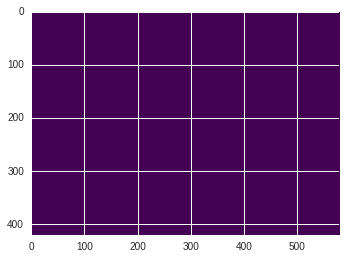

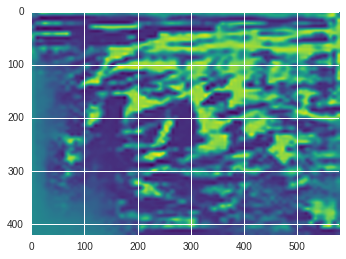

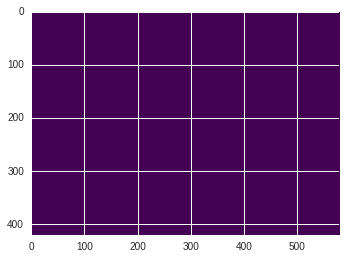

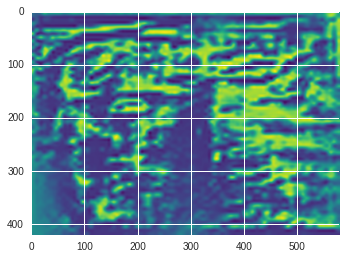

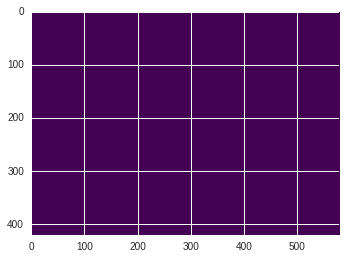

In [17]:
for i in range(0,5):
    pred = final_predictions[i][0]
    pred = cv2.resize(pred, (IMAGE_COLS, IMAGE_ROWS), interpolation=cv2.INTER_CUBIC)
    plt.imshow(pred, cmap='viridis')
    plt.show()

## Kaggle Results

- Public Leaderboard  -  Dice 0.63279  (Top 18%)
- Private Leaderboard -  Dice 0.62557  (Top 21%)
- JeffD23 at https://www.kaggle.com/c/ultrasound-nerve-segmentation/leaderboard